# Image Classification

# 1. Init.

In [2]:
import os, re, random, time
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import altair as alt
from PIL import Image
from sklearn.metrics import accuracy_score, f1_score
import copy
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import models, datasets, transforms
from torchvision.transforms import RandomErasing

import optuna
from optuna.trial import TrialState
import optuna.visualization as vis

#drive.mount('/content/drive')

dataset_path = r"C:\Users\Adminero\Documents\Study Material\Project\Image Classification\Dataset\iteration_2" # Each subfolder inside this dir should represent a class -> inside each subfolder are the images of this class

save_dir = r'C:\Users\Adminero\Documents\Study Material\Project\Image Classification\Runs'


# 2. Data Exploration and Visualization

## 2.1 Loading the Dataset and Visualizing the Images

In [ ]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

def get_random_samples(main_directory, k):
    samples = {}
    
    # Iterate over each subfolder in the main directory
    for subfolder in os.listdir(main_directory):
        subfolder_path = os.path.join(main_directory, subfolder)
        
        # Check if the path is a directory
        if os.path.isdir(subfolder_path):
            # Get all image files in the subfolder
            image_files = [file for file in os.listdir(subfolder_path) if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))]
            
            # Select k random samples from the image files
            if len(image_files) > 0:
                samples[subfolder] = random.sample(image_files, min(k, len(image_files)))
    
    return samples

def visualize_samples(main_directory, samples):
    # Calculate the number of rows and columns for the subplot grid
    num_classes = len(samples)
    num_samples = max(len(v) for v in samples.values())
    
    plt.figure(figsize=(num_samples * 3, num_classes * 3))
    
    # Iterate over each class and its samples
    for i, (class_name, image_files) in enumerate(samples.items()):
        for j, image_file in enumerate(image_files):
            image_path = os.path.join(main_directory, class_name, image_file)
            img = Image.open(image_path)
            
            # Create a subplot for each image
            plt.subplot(num_classes, num_samples, i * num_samples + j + 1)
            plt.imshow(img)
            plt.title(f'{class_name} - Sample {j+1}')
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

k = 3  # Define the number of samples to visualize per class

samples = get_random_samples(dataset_path, k)
visualize_samples(dataset_path, samples)


## 2.2 Class Distribution

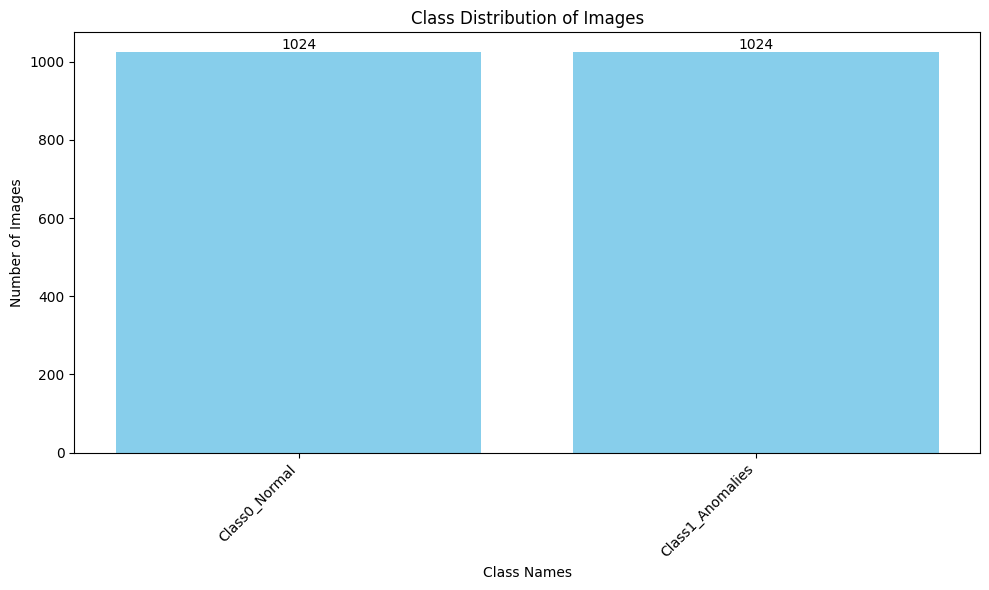

In [6]:
import os
import matplotlib.pyplot as plt

def count_images_in_subfolders(main_directory):
    class_counts = {}
    
    # Iterate over each subfolder in the main directory
    for subfolder in os.listdir(main_directory):
        subfolder_path = os.path.join(main_directory, subfolder)
        
        # Check if the path is a directory
        if os.path.isdir(subfolder_path):
            # Count the number of images in the subfolder
            image_count = len([file for file in os.listdir(subfolder_path) if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))])
            class_counts[subfolder] = image_count
    
    return class_counts

def plot_class_distribution(class_counts):
    # Extract class names and their respective counts
    classes = list(class_counts.keys())
    counts = list(class_counts.values())
    
    # Plot the bar chart
    plt.figure(figsize=(10, 6))
    bars = plt.bar(classes, counts, color='skyblue')
    plt.xlabel('Class Names')
    plt.ylabel('Number of Images')
    plt.title('Class Distribution of Images')
    plt.xticks(rotation=45, ha='right')
    
    # Add the number of images on top of each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, yval, va='bottom', ha='center')
    
    plt.tight_layout()
    plt.show()

class_counts = count_images_in_subfolders(dataset_path)
plot_class_distribution(class_counts)


---

# 3. Data Preprocessing

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import RandomErasing

num_classes = 2

# Define transformations for training, validation, and test sets
train_transforms = transforms.Compose([
    #transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Randomly crop and resize to 224x224
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize with ImageNet mean and std
    #RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value='random')  # Randomly erase a rectangle region with 50% probability
])

val_test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    #transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the dataset
dataset = datasets.ImageFolder(root=dataset_path, transform=train_transforms)

# Split the dataset into training, validation, and test sets
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Apply validation/test transformations to the validation and test sets
val_dataset.dataset.transform = val_test_transforms
test_dataset.dataset.transform = val_test_transforms

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=8)

## Visualize loaders

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img, title=None):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title is not None:
        plt.title(title)
    plt.show()

def visualize_random_images(data_loader, num_images=5):
    # Get a batch of images from the data loader
    data_iter = iter(data_loader)
    images, labels = next(data_iter)

    # Select random indices
    indices = np.random.choice(range(len(images)), num_images, replace=False)

    # Visualize the images
    for idx in indices:
        imshow(images[idx], title=f'Label: {labels[idx]}')

# Visualize random images from train, validation, and test loaders
print("Train Loader Images:")
visualize_random_images(train_loader)

print("Validation Loader Images:")
visualize_random_images(val_loader)

print("Test Loader Images:")
visualize_random_images(test_loader)

---

# Training and Validation

## Main Training Script

In [11]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True)

model.fc = nn.Linear(model.fc.in_features, num_classes)

model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # weight_decay for L2 regularization
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# Early stopping parameters
patience = 5
best_val_loss = float('inf')
best_model_wts = copy.deepcopy(model.state_dict())
early_stop_counter = 0

# Training loop
num_epochs = 3

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 10)

    # Training phase
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / train_size
    epoch_acc = running_corrects.double() / train_size

    print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_running_corrects = 0

    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        val_running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        val_running_corrects += torch.sum(preds == labels.data)

    val_loss = val_running_loss / val_size
    val_acc = val_running_corrects.double() / val_size

    print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

    # Check for improvement
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        early_stop_counter = 0
    else:
        early_stop_counter += 1

    # Adjust learning rate
    scheduler.step(val_loss)

    # Early stopping
    if early_stop_counter >= patience:
        print("Early stopping")
        break

# Load best model weights
model.load_state_dict(best_model_wts)

# Save the best model
torch.save(model.state_dict(), os.path.join(save_dir, 'best_model_it2.pth'))

print("Training Complete! 🥳🎉")

Epoch 1/3
----------
Train Loss: 0.4250 Acc: 0.8297
Val Loss: 0.2924 Acc: 0.8824
Epoch 2/3
----------
Train Loss: 0.2420 Acc: 0.9176
Val Loss: 0.2595 Acc: 0.8922
Epoch 3/3
----------
Train Loss: 0.1932 Acc: 0.9335
Val Loss: 0.1821 Acc: 0.9363


## Validate on Test

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the trained model
num_classes = 2
model = models.resnet18()
model.fc = nn.Linear(model.fc.in_features, num_classes)
model_path = r'C:\Users\Adminero\Documents\Study Material\Project\Image Classification\Runs\best_model_it2.pth'
model.load_state_dict(torch.load(model_path))
model.to(device)


model.eval()
test_running_corrects = 0

for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    test_running_corrects += torch.sum(preds == labels.data)

test_acc = test_running_corrects.double() / test_size
print(f'Test Acc: {test_acc:.4f}')

Test Acc: 0.9320


## Validate on folder with custom

In [11]:
import torch
import torch.nn as nn
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, random_split

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the trained model
num_classes = 2
model = models.resnet18()
model.fc = nn.Linear(model.fc.in_features, num_classes)
model_path = r'C:\Users\Adminero\Documents\Study Material\Project\Image Classification\Runs\best_model.pth'
model.load_state_dict(torch.load(model_path))
model.to(device)

# Define transformations for the test set
test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the test dataset
dataset_path = r"C:\Users\Adminero\Documents\Study Material\Project\Image Classification\Dataset"
dataset = datasets.ImageFolder(root=dataset_path, transform=test_transforms)

# Split the dataset to get the test set
train_size = int(0 * len(dataset))
val_size = int(0 * len(dataset))
test_size = len(dataset) - train_size - val_size

_, _, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create test data loader
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=8)

# Testing the model
model.eval()
test_running_corrects = 0

for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    test_running_corrects += torch.sum(preds == labels.data)

test_acc = test_running_corrects.double() / test_size
print(f'Test Acc: {test_acc:.4f}')

Test Acc: 0.9305


## Validate on 1 Picture

In [13]:
from PIL import Image
import torch
import torch.nn as nn
from torchvision import models, transforms

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the trained model
num_classes = 2
model = models.resnet18()
model.fc = nn.Linear(model.fc.in_features, num_classes)
model_path = r'C:\Users\Adminero\Documents\Study Material\Project\Image Classification\Runs\best_model.pth'
model.load_state_dict(torch.load(model_path))
model.to(device)
model.eval()

# Define transformations for the image
image_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load and preprocess the image
image_path = r"C:\Users\Adminero\Documents\Study Material\Project\Image Classification\Dataset\Class1_Anomalies\n008-2018-05-21-11-06-59-0400__CAM_FRONT__1526915294412465.jpg"  # Replace with your image path
image = Image.open(image_path)
image = image_transforms(image).unsqueeze(0)  # Add batch dimension

# Move the image to the GPU
image = image.to(device)

# Make prediction
with torch.no_grad():
    output = model(image)
    _, prediction = torch.max(output, 1)

# Print the prediction
print(f'Predicted class: {prediction.item()}')

Predicted class: 1


## Validate on Directory

In [15]:
import os
from PIL import Image
import torch
import torch.nn as nn
from torchvision import models, transforms

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the trained model
num_classes = 2
model = models.resnet18()
model.fc = nn.Linear(model.fc.in_features, num_classes)
model_path = r'C:\Users\Adminero\Documents\Study Material\Project\Image Classification\Runs\best_model.pth'
model.load_state_dict(torch.load(model_path))
model.to(device)
model.eval()

# Define transformations for the images
image_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Directory containing images
image_directory = r"C:\Users\Adminero\Documents\Study Material\Project\Image Classification\Dataset\Class1_Anomalies"  # Replace with your directory path

# Initialize counters for each class
class_counts = [0] * num_classes
total_images = 0

# Iterate over all images in the directory
for filename in os.listdir(image_directory):
    if filename.endswith(('.png', '.jpg', '.jpeg')):  # Check for valid image file extensions
        image_path = os.path.join(image_directory, filename)
        image = Image.open(image_path)
        image = image_transforms(image).unsqueeze(0)  # Add batch dimension
        image = image.to(device)

        # Make prediction
        with torch.no_grad():
            output = model(image)
            _, prediction = torch.max(output, 1)
            class_counts[prediction.item()] += 1
            total_images += 1

# Calculate and print the percentage of each class
for i, count in enumerate(class_counts):
    percentage = (count / total_images) * 100
    print(f'Class {i}: {percentage:.2f}%')

Class 0: 7.70%
Class 1: 92.30%


---

# Grad CAMs

## One image local model

In [ ]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torchcam.methods import GradCAM, GradCAMpp, ScoreCAM, SSCAM, ISCAM
from torchcam.utils import overlay_mask
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Initialize the ResNet-18 model
model = models.resnet18()

num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, num_classes)
)

# Load the saved weights into the model
model.load_state_dict(torch.load(r"C:\Users\Adminero\Documents\Study Material\Project\Image Classification\Runs\best_model.pth"))

# Set the model to evaluation mode
model.eval()

img_path = r"C:\Users\Adminero\Documents\n01514859_hen.JPEG"  # Replace with your image path

# Load and preprocess the image
image = Image.open(img_path)
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(image).unsqueeze(0)

# Initialize Grad-CAM

cam_extractor = GradCAMpp(model, target_layer='layer4')

# Forward pass
output = model(input_tensor)

# Generate Grad-CAM heatmap
activation_map = cam_extractor(class_idx=torch.argmax(output[0]).item(), scores=output)

# Convert activation map to a numpy array and normalize
activation_map = activation_map[0].squeeze().cpu().numpy()
activation_map = (activation_map - activation_map.min()) / (activation_map.max() - activation_map.min())  # Normalize

# Resize the activation map to the original image size using interpolation
activation_map = cv2.resize(activation_map, (image.size[0], image.size[1]), interpolation=cv2.INTER_LINEAR)

# Apply a colormap to the heatmap
heatmap = cv2.applyColorMap(np.uint8(255 * activation_map), cv2.COLORMAP_JET)

# Convert heatmap to RGB (OpenCV uses BGR by default)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

# Overlay the heatmap on the original image
overlayed_image = Image.blend(image.convert("RGB"), Image.fromarray(heatmap), alpha=0.5)

# Display the result
plt.imshow(overlayed_image)
plt.axis('off')
plt.show()

## One image local model attempt 2 GPU

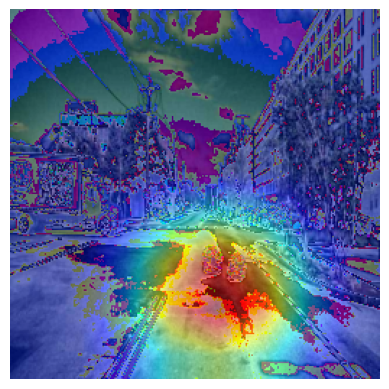

In [27]:
from PIL import Image
import torch
import torch.nn as nn
from torchvision import models, transforms
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torchcam.methods import GradCAM, GradCAMpp, ScoreCAM, SSCAM, ISCAM
from torchcam.utils import overlay_mask
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the trained model
num_classes = 2
model = models.resnet18()
model.fc = nn.Linear(model.fc.in_features, num_classes)
model_path = r'C:\Users\Adminero\Documents\Study Material\Project\Image Classification\Runs\best_model.pth'
model.load_state_dict(torch.load(model_path))
model.to(device)
model.eval()

# Define transformations for the image
image_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load and preprocess the image
image_path = r"C:\Users\Adminero\Documents\Study Material\Project\Image Classification\Dataset\Class1_Anomalies\n008-2018-08-01-15-52-19-0400__CAM_FRONT__1533153466862404.jpg"  # Replace with your image path
image = Image.open(image_path)
image = image_transforms(image).unsqueeze(0)  # Add batch dimension

# Move the image to the same device as the model
image = image.to(device)

# Initialize Grad-CAM
cam_extractor = GradCAMpp(model, target_layer='layer4')

# Forward pass
output = model(image)

# Generate Grad-CAM heatmap
activation_map = cam_extractor(class_idx=torch.argmax(output[0]).item(), scores=output)

# Convert activation map to a numpy array and normalize
activation_map = activation_map[0].squeeze().cpu().numpy()
activation_map = (activation_map - activation_map.min()) / (activation_map.max() - activation_map.min())  # Normalize

# Resize the activation map to the original image size using interpolation
activation_map = cv2.resize(activation_map, (image.shape[2], image.shape[3]), interpolation=cv2.INTER_LINEAR)

# Apply a colormap to the heatmap
heatmap = cv2.applyColorMap(np.uint8(255 * activation_map), cv2.COLORMAP_JET)

# Convert heatmap to RGB (OpenCV uses BGR by default)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

# Convert the tensor to a PIL Image
original_image = transforms.ToPILImage()(image.squeeze().cpu())

# Overlay the heatmap on the original image
overlayed_image = Image.blend(original_image.convert("RGB"), Image.fromarray(heatmap), alpha=0.5)

# Display the result
plt.imshow(overlayed_image)
plt.axis('off')
plt.show()

## One image local model attempt 2 CPU

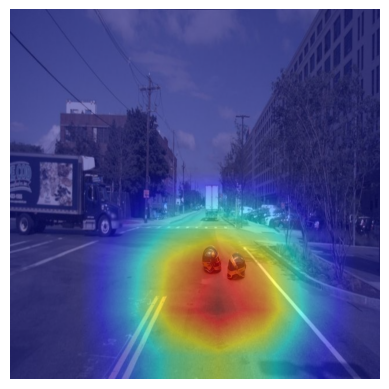

In [12]:
from PIL import Image
import torch
import torch.nn as nn
from torchvision import models, transforms
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torchcam.methods import GradCAM, GradCAMpp, ScoreCAM, SSCAM, ISCAM
from torchcam.utils import overlay_mask
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Load the trained model
num_classes = 2
model = models.resnet18()
model.fc = nn.Linear(model.fc.in_features, num_classes)
model_path = r'C:\Users\Adminero\Documents\Study Material\Project\Image Classification\Runs\best_model.pth'
model.load_state_dict(torch.load(model_path))
model.eval()

# Define transformations for the image
image_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load and preprocess the image
image_path = r"C:\Users\Adminero\Documents\Study Material\Project\Image Classification\Dataset\Class1_Anomalies\n008-2018-08-01-15-52-19-0400__CAM_FRONT__1533153466862404.jpg"  # Replace with your image path
image = Image.open(image_path)
image = image_transforms(image).unsqueeze(0)  # Add batch dimension


# Initialize Grad-CAM

# Load the original image to get its dimensions
original_image = Image.open(image_path)
original_width, original_height = original_image.size

# Preprocess the image
image = image_transforms(original_image).unsqueeze(0)  # Add batch dimension

# Initialize Grad-CAM
cam_extractor = GradCAMpp(model, target_layer='layer4')

# Forward pass
output = model(image)

# Generate Grad-CAM heatmap
activation_map = cam_extractor(class_idx=torch.argmax(output[0]).item(), scores=output)

# Convert activation map to a numpy array and normalize
activation_map = activation_map[0].squeeze().cpu().numpy()
activation_map = (activation_map - activation_map.min()) / (activation_map.max() - activation_map.min())  # Normalize

# Resize the activation map to the original image size using interpolation
activation_map = cv2.resize(activation_map, (original_width, original_height), interpolation=cv2.INTER_LINEAR)

# Apply a colormap to the heatmap
heatmap = cv2.applyColorMap(np.uint8(255 * activation_map), cv2.COLORMAP_JET)

# Convert heatmap to RGB (OpenCV uses BGR by default)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

# Overlay the heatmap on the original image
overlayed_image = Image.blend(original_image.convert("RGB"), Image.fromarray(heatmap), alpha=0.5)

# Display the result
plt.imshow(overlayed_image)
plt.axis('off')
plt.show()

## One image Imagenet

C:\Users\Adminero\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Adminero\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


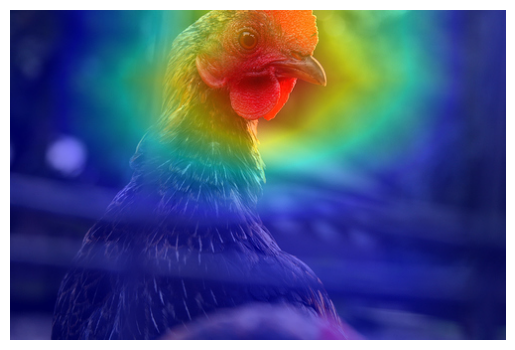

In [1]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torchcam.methods import GradCAM, GradCAMpp, ScoreCAM, SSCAM, ISCAM
from torchcam.utils import overlay_mask
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Load a pretrained model
model = models.resnet18(pretrained=True)
model.eval()
img_path = r"C:\Users\Adminero\Documents\n01514859_hen.JPEG"  # Replace with your image path

# Load and preprocess the image
image = Image.open(img_path)
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(image).unsqueeze(0)

# Initialize Grad-CAM
#cam_extractor = GradCAM(model, target_layer='layer4')
cam_extractor = GradCAMpp(model, target_layer='layer4')
#cam_extractor = ScoreCAM(model, target_layer='layer4')
#cam_extractor = SSCAM(model, target_layer='layer4')
#cam_extractor = ISCAM(model, target_layer='layer4')

# Forward pass
output = model(input_tensor)

# Generate Grad-CAM heatmap
activation_map = cam_extractor(class_idx=torch.argmax(output[0]).item(), scores=output)

# Convert activation map to a numpy array and normalize
activation_map = activation_map[0].squeeze().cpu().numpy()
activation_map = (activation_map - activation_map.min()) / (activation_map.max() - activation_map.min())  # Normalize

# Resize the activation map to the original image size using interpolation
activation_map = cv2.resize(activation_map, (image.size[0], image.size[1]), interpolation=cv2.INTER_LINEAR)

# Apply a colormap to the heatmap
heatmap = cv2.applyColorMap(np.uint8(255 * activation_map), cv2.COLORMAP_JET)

# Convert heatmap to RGB (OpenCV uses BGR by default)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

# Overlay the heatmap on the original image
overlayed_image = Image.blend(image.convert("RGB"), Image.fromarray(heatmap), alpha=0.5)

# Display the result
plt.imshow(overlayed_image)
plt.axis('off')
plt.show()

## Predictions stats

In [7]:
import os
import json
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import numpy as np

# Load a pretrained model
# Initialize the ResNet-18 model
model = models.resnet18()

model.fc = nn.Linear(model.fc.in_features, num_classes)


# Load the saved weights into the model
model.load_state_dict(torch.load(r"C:\Users\Adminero\Documents\Study Material\Project\Image Classification\Runs\best_model.pth"))

# Define your custom labels
labels = ["Class0_Normal", "Class1_Anomalies"]  # Replace with your actual labels

# Define the directory containing images
image_dir = r"C:\Users\Adminero\Documents\Study Material\Project\Image Classification\Dataset\Class0_Normal"

# Preprocessing function
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Initialize a dictionary to count predictions
prediction_counts = {label: 0 for label in labels}

# Loop through all images in the directory
for img_name in os.listdir(image_dir):
    img_path = os.path.join(image_dir, img_name)
    
    # Check if the file is an image
    if img_path.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
        # Load and preprocess the image
        image = Image.open(img_path)
        input_tensor = preprocess(image).unsqueeze(0)

        # Forward pass
        output = model(input_tensor)

        # Get the predicted class index
        class_idx = torch.argmax(output[0]).item()
        
        # Ensure the class index is within the range of your custom labels
        if class_idx < len(labels):
            class_name = labels[class_idx]
            prediction_counts[class_name] += 1
        else:
            prediction_counts["Unknown"] = prediction_counts.get("Unknown", 0) + 1

# Print the prediction statistics
print("Prediction Statistics:")
for label, count in prediction_counts.items():
    print(f"{label}: {count}")

Prediction Statistics:
Class0_Normal: 0
Class1_Anomalies: 870


## Directory local model

In [ ]:
import os
import json
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torchcam.methods import GradCAMpp  # You can switch to other methods like GradCAM, ScoreCAM, etc.
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
import requests

# Load a pretrained model
# Initialize the ResNet-18 model
model = models.resnet18()
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, num_classes)
)
# Load the saved weights into the model
model.load_state_dict(torch.load(r"C:\Users\Adminero\Documents\Study Material\Project\Image Classification\Runs\best_model.pth"))


# Define your custom labels
labels = ["Class0_Normal", "Class1_Anomalies"]  # Replace with your actual labels

# Define the directory containing images
#image_dir = r"C:\Users\Adminero\Documents\Study Material\Project\Image Classification\Test Dataset"  # Replace with your directory path
image_dir = r"C:\Users\Adminero\Documents\Study Material\Project\Image Classification\Dataset\Class0_Normal"

# Preprocessing function
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Initialize Grad-CAM
cam_extractor = GradCAMpp(model, target_layer='layer4')

# Loop through all images in the directory
for img_name in os.listdir(image_dir):
    img_path = os.path.join(image_dir, img_name)
    
    # Check if the file is an image
    if img_path.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
        # Load and preprocess the image
        image = Image.open(img_path)
        input_tensor = preprocess(image).unsqueeze(0)

        # Forward pass
        output = model(input_tensor)

        # Get the predicted class index
        class_idx = torch.argmax(output[0]).item()
        
        # Ensure the class index is within the range of your custom labels
        if class_idx < len(labels):
            class_name = labels[class_idx]
        else:
            class_name = "Unknown"

        # Generate Grad-CAM heatmap
        activation_map = cam_extractor(class_idx=class_idx, scores=output)

        # Convert activation map to a numpy array and normalize
        activation_map = activation_map[0].squeeze().cpu().numpy()
        activation_map = (activation_map - activation_map.min()) / (activation_map.max() - activation_map.min())  # Normalize

        # Resize the activation map to the original image size using interpolation
        activation_map = cv2.resize(activation_map, (image.size[0], image.size[1]), interpolation=cv2.INTER_LINEAR)

        # Apply a colormap to the heatmap
        heatmap = cv2.applyColorMap(np.uint8(255 * activation_map), cv2.COLORMAP_JET)

        # Convert heatmap to RGB (OpenCV uses BGR by default)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

        # Overlay the heatmap on the original image
        overlayed_image = Image.blend(image.convert("RGB"), Image.fromarray(heatmap), alpha=0.5)

        # Display the result with prediction
        plt.imshow(overlayed_image)
        plt.axis('off')
        plt.title(f"Grad-CAM for {img_name}\nPrediction: {class_name}")
        plt.show()

## Directory local model attemp 2 (CURRENT)

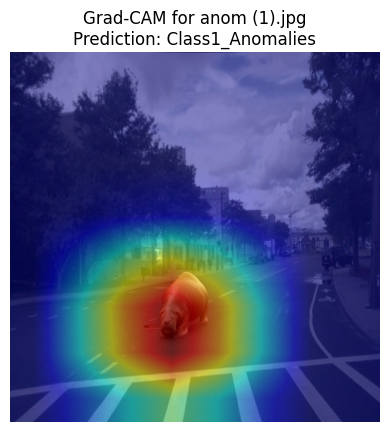

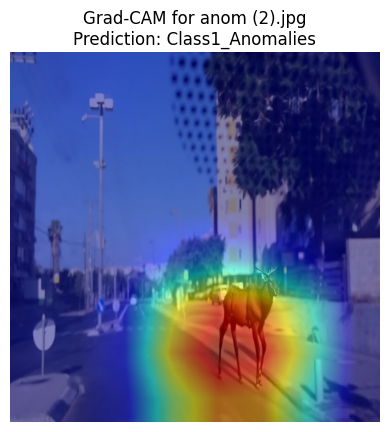

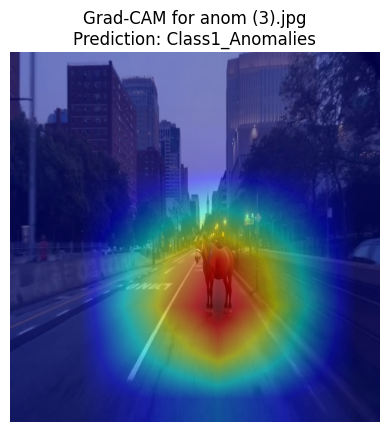

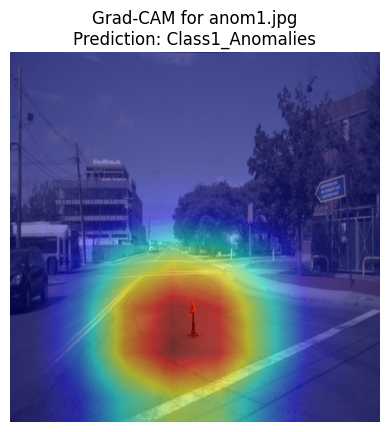

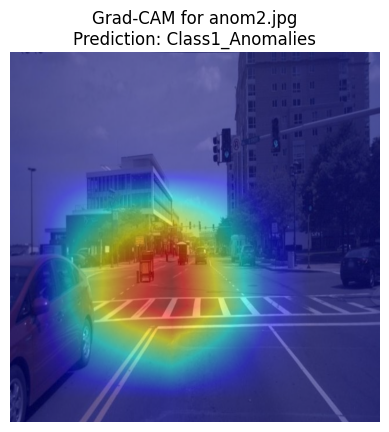

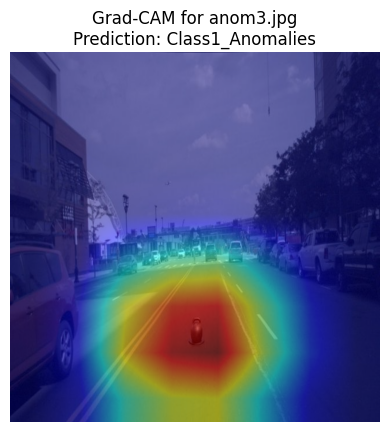

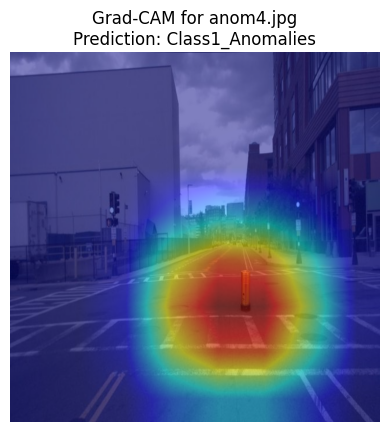

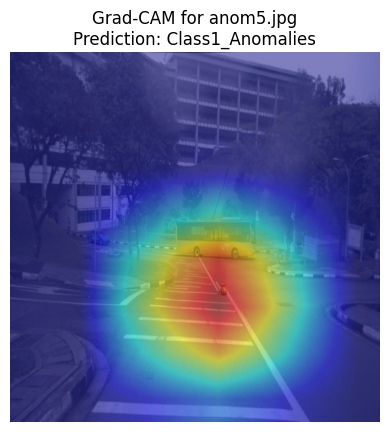

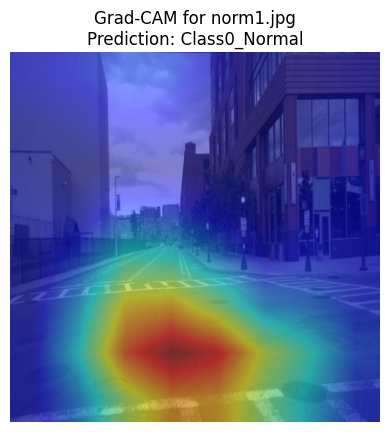

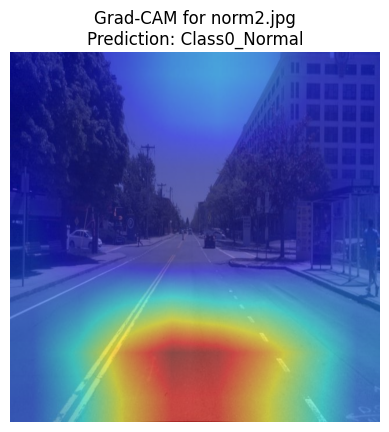

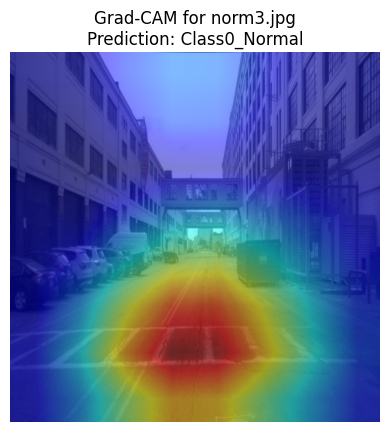

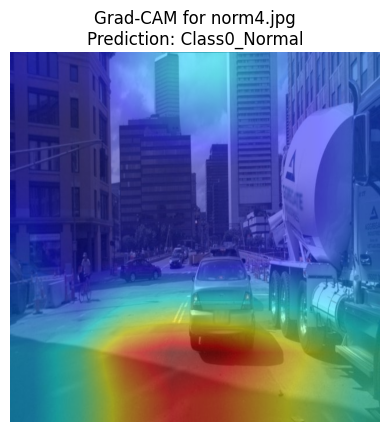

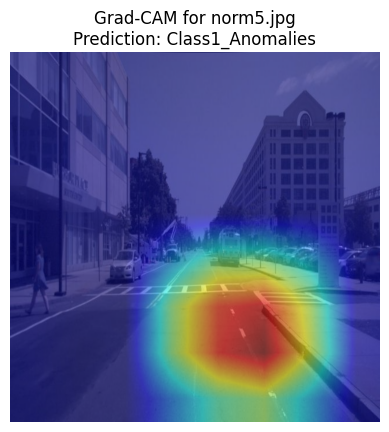

In [14]:
import os
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torchcam.methods import GradCAMpp
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Load the trained model
num_classes = 2
model = models.resnet18()
model.fc = nn.Linear(model.fc.in_features, num_classes)
model_path = r'C:\Users\Adminero\Documents\Study Material\Project\Image Classification\Runs\best_model_it2.pth'
model.load_state_dict(torch.load(model_path))
model.eval()

# Define transformations for the image
image_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define your custom labels
labels = ["Class0_Normal", "Class1_Anomalies"]  # Replace with your actual labels

# Define the directory containing images
image_dir = r"C:\Users\Adminero\Documents\Study Material\Project\Image Classification\Test Dataset"  # Replace with your directory path

# Initialize Grad-CAM
cam_extractor = GradCAMpp(model, target_layer='layer4')

# Loop through all images in the directory
for img_name in os.listdir(image_dir):
    img_path = os.path.join(image_dir, img_name)
    
    # Check if the file is an image
    if img_path.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
        # Load and preprocess the image
        image = Image.open(img_path)
        input_tensor = image_transforms(image).unsqueeze(0)

        # Forward pass
        output = model(input_tensor)

        # Get the predicted class index
        class_idx = torch.argmax(output[0]).item()
        
        # Ensure the class index is within the range of your custom labels
        if class_idx < len(labels):
            class_name = labels[class_idx]
        else:
            class_name = "Unknown"

        # Generate Grad-CAM heatmap
        activation_map = cam_extractor(class_idx=class_idx, scores=output)

        # Convert activation map to a numpy array and normalize
        activation_map = activation_map[0].squeeze().cpu().numpy()
        activation_map = (activation_map - activation_map.min()) / (activation_map.max() - activation_map.min())  # Normalize

        # Resize the activation map to the original image size using interpolation
        activation_map = cv2.resize(activation_map, (image.size[0], image.size[1]), interpolation=cv2.INTER_LINEAR)

        # Apply a colormap to the heatmap
        heatmap = cv2.applyColorMap(np.uint8(255 * activation_map), cv2.COLORMAP_JET)

        # Convert heatmap to RGB (OpenCV uses BGR by default)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

        # Overlay the heatmap on the original image
        overlayed_image = Image.blend(image.convert("RGB"), Image.fromarray(heatmap), alpha=0.5)

        # Display the result with prediction
        plt.imshow(overlayed_image)
        plt.axis('off')
        plt.title(f"Grad-CAM for {img_name}\nPrediction: {class_name}")
        plt.show()

## Directory Imagenet

In [ ]:
import os
import json
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torchcam.methods import GradCAMpp  # You can switch to other methods like GradCAM, ScoreCAM, etc.
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
import requests

# Load a pretrained model
model = models.resnet18(pretrained=True)
model.eval()

# Load ImageNet class labels
LABELS_URL = 'https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json'
response = requests.get(LABELS_URL)
labels = response.json()

# Define the directory containing images
image_dir = r"C:\Users\Adminero\Documents\imagenet-sample-images-master"  # Replace with your directory path

# Preprocessing function
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Initialize Grad-CAM
cam_extractor = GradCAMpp(model, target_layer='layer4')

# Loop through all images in the directory
for img_name in os.listdir(image_dir):
    img_path = os.path.join(image_dir, img_name)
    
    # Check if the file is an image
    if img_path.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
        # Load and preprocess the image
        image = Image.open(img_path)
        input_tensor = preprocess(image).unsqueeze(0)

        # Forward pass
        output = model(input_tensor)

        # Get the predicted class index
        class_idx = torch.argmax(output[0]).item()
        class_name = labels[class_idx]

        # Generate Grad-CAM heatmap
        activation_map = cam_extractor(class_idx=class_idx, scores=output)

        # Convert activation map to a numpy array and normalize
        activation_map = activation_map[0].squeeze().cpu().numpy()
        activation_map = (activation_map - activation_map.min()) / (activation_map.max() - activation_map.min())  # Normalize

        # Resize the activation map to the original image size using interpolation
        activation_map = cv2.resize(activation_map, (image.size[0], image.size[1]), interpolation=cv2.INTER_LINEAR)

        # Apply a colormap to the heatmap
        heatmap = cv2.applyColorMap(np.uint8(255 * activation_map), cv2.COLORMAP_JET)

        # Convert heatmap to RGB (OpenCV uses BGR by default)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

        # Overlay the heatmap on the original image
        overlayed_image = Image.blend(image.convert("RGB"), Image.fromarray(heatmap), alpha=0.5)

        # Display the result with prediction
        plt.imshow(overlayed_image)
        plt.axis('off')
        plt.title(f"Grad-CAM for {img_name}\nPrediction: {class_name}")
        plt.show()

---

---